In [88]:
!pip install dash

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import dash
from dash import html, dcc, Input, Output
from dash.dependencies import Input, Output
import threading
from google.colab import output

In [2]:
df_covid = pd.read_csv('project_1_python.csv')

In [4]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180477 entries, 0 to 180476
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    180477 non-null  int64  
 1   iso_code                 180477 non-null  object 
 2   continent                180477 non-null  object 
 3   location                 180477 non-null  object 
 4   date                     180477 non-null  object 
 5   total_cases              173493 non-null  float64
 6   new_cases                173212 non-null  float64
 7   total_deaths             155323 non-null  float64
 8   new_deaths               155095 non-null  float64
 9   hosp_patients            27152 non-null   float64
 10  total_tests              78326 non-null   float64
 11  new_tests                74509 non-null   float64
 12  tests_per_case           92600 non-null   float64
 13  total_vaccinations       46366 non-null   float64
 14  peop

In [6]:
df_population = df_covid[['location', 'population']].drop_duplicates()
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 0 to 179656
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    226 non-null    object 
 1   population  226 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [7]:
df_population = df_population.sort_values(by='population', ascending=False).head(10)

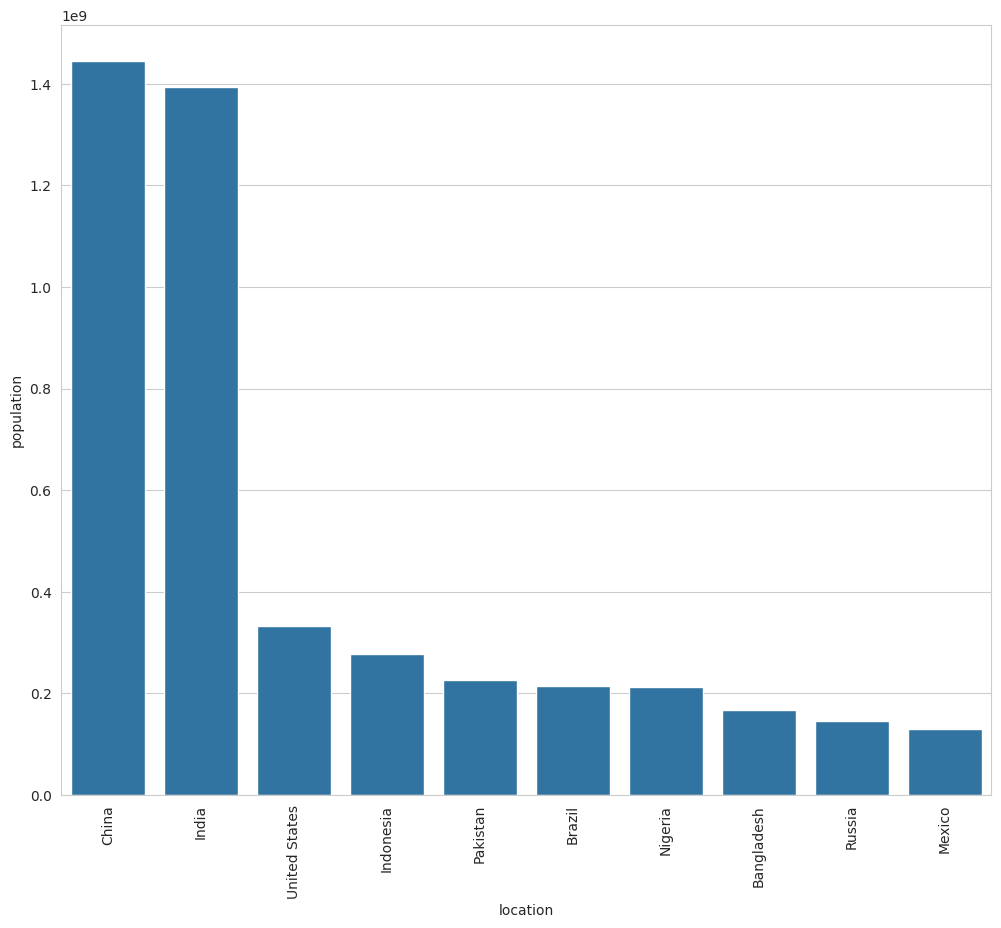

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,10))
population_barplot = sns.barplot(df_population, x='location', y='population')
plt.xticks(rotation=90)
plt.show()


In [19]:
df_life = df_covid[['location', 'population', 'continent', 'life_expectancy']].drop_duplicates()



In [25]:
px.scatter(data_frame=df_life, x='population', y='life_expectancy', color='continent', log_x=True, hover_name='location', color_discrete_sequence=px.colors.qualitative.G10, width=800, height=400, title='Life expectancy vs. population and continent')

In [29]:
df_compare_new_cases = df_covid[['location', 'date', 'new_cases']]
selected_countries = ['Germany', 'Greece']
df_compare_new_cases = df_compare_new_cases[df_compare_new_cases['location'].isin(selected_countries)]
df_compare_new_cases

,location,date,new_cases
60677,Germany,2020-01-27,1.0
60678,Germany,2020-01-28,3.0
60679,Germany,2020-01-29,0.0
60680,Germany,2020-01-30,0.0
60681,Germany,2020-01-31,1.0
...,...,...,...
64057,Greece,2022-06-14,8121.0
64058,Greece,2022-06-15,9288.0
64059,Greece,2022-06-16,7158.0
64060,Greece,2022-06-17,7204.0


In [36]:
px.line(data_frame=df_compare_new_cases,
                          x='date', y='new_cases',
                          color='location',
                          color_discrete_sequence=px.colors.qualitative.G10,
                          title='COVID-19 - new cases in Greece and Germany')

In [49]:
max_date = df_covid['date'].max()
df_total_cases = df_covid[df_covid['date'] == max_date]
df_total_cases['cases_per_person'] = df_total_cases['total_cases'] / df_total_cases['population'] * 1000


<ipython-input-49-956be077cc2f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
my_mapbox_token = 'pk.eyJ1IjoibHVpcGVub3giLCJhIjoiY20xMXc4ZzZqMHY1ZDJvcjM3ZHAycHIxMCJ9.5r-oJCpCFTW6tNdIFfq6lA'
px.set_mapbox_access_token(my_mapbox_token)

In [64]:
px.scatter_mapbox(df_total_cases,
                                  lat='latitude', lon='longitude',
                                  color='continent',
                                  size='cases_per_person',
                                  size_max=15,

                                  color_discrete_sequence=px.colors.qualitative.G10,
                                  hover_name='location',
                                  hover_data={'continent': False,
                                              'total_cases': True,
                                              'cases_per_person': True,
                                              'latitude': False},
                                  zoom=1,
                                  mapbox_style='dark',
                                  title='COVID-19 - cases per person')

In [75]:
df_selected_country = df_covid[df_covid['location'] == 'Greece']
px.line(df_selected_country, x ='date', y='total_deaths', labels={'total_deaths': 'Total deaths','date': 'Date'}, title='Total deaths in Greece')

In [94]:
app = dash.Dash()

countries = df_covid['location'].unique()

app.layout = html.Div([
        html.H1('Cumulative number of positive cases', id='header'),
        html.P('Select country: '),
        dcc.Dropdown(id='dropdown-country', options=countries, value=countries[0]),

        html.Div([
          dcc.Graph(id='graph-cases'),
          dcc.Graph(id='graph-deaths')
        ], style={'display': 'flex', 'flex-direction': 'row', 'justify-content': 'space-around', 'width': '100%'})


    ])

@app.callback(
    [Output('graph-cases', 'figure'),
     Output('graph-deaths', 'figure')],
    Output('header', 'children'),
    [Input('dropdown-country', 'value')]
)

def update_graphs(country):
    df_selected_country = df_covid[df_covid['location'] == country]
    figure_cases = px.line(df_selected_country, x ='date', y='total_cases', labels={'total_cases': 'Total cases','date': 'Date'}, title=f'Total cases in {country}')
    figure_deaths = px.line(df_selected_country, x ='date', y='total_deaths', labels={'total_deaths': 'Total deaths','date': 'Date'}, title=f'Total deaths in {country}')
    header = f'Total number of positive cases in {country}'
    return figure_cases, figure_deaths


thread = threading.Thread(target=app.run)
thread.start()
output.serve_kernel_port_as_iframe(port=8050, height=800)

<IPython.core.display.Javascript object>

In [100]:
max_date = df_covid['date'].max()
df_cases = df_covid[df_covid['date'] == max_date].fillna(0)


In [95]:
px.scatter_mapbox(df_cases,
                                  lat='latitude', lon='longitude',
                                  color='continent',
                                  size='cases_per_person',
                                  size_max=15,

                                  color_discrete_sequence=px.colors.qualitative.G10,
                                  hover_name='location',
                                  hover_data={'continent': False,
                                              'total_cases': True,
                                              'cases_per_person': True,
                                              'latitude': False},
                                  zoom=1,
                                  mapbox_style='dark',
                                  title='COVID-19 - cases per person')

In [142]:
my_mapbox_token = 'pk.eyJ1IjoibHVpcGVub3giLCJhIjoiY20xMXc4ZzZqMHY1ZDJvcjM3ZHAycHIxMCJ9.5r-oJCpCFTW6tNdIFfq6lA'
px.set_mapbox_access_token(my_mapbox_token)

In [147]:


app = dash.Dash()
continents= df_covid['continent'].unique()
option_cases={'total_cases': 'Total Cases',
              'total_deaths': 'Total Deaths',
              'total_test': 'Total Test',
              'total_vaccinations': 'Total Vaccinations',
              'people_vaccinated': 'People Vaccinated'}
app.layout = html.Div([
    html.H1('COVID-19 - {metric} in {continent}', id='header'),
    dcc.Dropdown(id='dropdown-continent',
                 options=continents,
                 value=continents[0]
    ),
    dcc.Dropdown(id='dropdown-metric',
                 options=option_cases,
                 value=option_cases['total_cases']
    ),
    dcc.Graph(id='graph-map')
])
@app.callback(
    Output('graph-map', 'figure'),
    Output('header', 'children'),
    Input('dropdown-continent', 'value'),
    Input('dropdown-metric', 'value')
)
def update_graph(continent, metric):
  figure = px.scatter_mapbox(df_cases[df_cases['continent'] == continent],
                  lat='latitude',
                  lon='longitude',
                  zoom=1,
                  color='continent',
                  size_max=15,
                  size= metric,
                  hover_name='location',
                  hover_data={
                       metric: True,
                      'total_deaths': True,
                      'latitude': False,
                      'longitude': False,
                      'location': True
                  },
                  mapbox_style='dark',
                  #title='Map of Covid cases'
  )
  header=f'COVID-19 - {metric} in {continent}'
  return figure, header
thread = threading.Thread(target=app.run)
thread.start()
output.serve_kernel_port_as_iframe(port=8050, height=800)

<IPython.core.display.Javascript object>

In [151]:
max_date = df_covid['date'].max()
df_cases = df_covid[df_covid['date'] == max_date]
df_vaccinations = df_cases[['location', 'total_vaccinations', 'population']].dropna()
df_vaccinations['vaccinations_per_person'] = df_vaccinations['total_vaccinations'] / df_vaccinations['population'] * 1000

df_total_vaccinations = df_vaccinations.sort_values(by='total_vaccinations', ascending=False)
df_vaccinations_per_person = df_vaccinations.sort_values(by='vaccinations_per_person', ascending=False)

display(df_total_vaccinations.head(5))
display(df_vaccinations_per_person.head(5))

,location,total_vaccinations,population,vaccinations_per_person
34377,China,3.394504e+09,1.444216e+09,2350.412792
75440,India,1.959268e+09,1.393409e+09,1406.097019
22648,Brazil,4.492916e+08,2.139934e+08,2099.557790
13495,Bangladesh,2.753066e+08,1.663035e+08,1655.447167
123842,Pakistan,2.586801e+08,2.251999e+08,1148.668741


,location,total_vaccinations,population,vaccinations_per_person
173471,Uruguay,8.584015e+06,3.485152e+06,2463.024568
151218,South Korea,1.258424e+08,5.130518e+07,2452.821278
34377,China,3.394504e+09,1.444216e+09,2350.412792
81358,Italy,1.380822e+08,6.036747e+07,2287.360274
96431,Macao,1.434636e+06,6.583910e+05,2179.003054


In [153]:
px.bar(df_total_vaccinations.head(5), x='location', y='total_vaccinations', title='Total vaccinations in each country')

In [155]:
px.bar(df_vaccinations_per_person.head(5), x='location', y='vaccinations_per_person')

In [162]:
app = dash.Dash()


app.layout = html.Div([
        html.H1('Top {count} country in vaccinations', id='header'),
        dcc.Slider(0, 20, 5, value=5, id='slider-count'),

        html.Div([
          dcc.Graph(id='graph-total'),
          dcc.Graph(id='graph-person'),
        ], style={'display': 'flex', 'flex-direction': 'row', 'justify-content': 'space-around', 'width': '100%'})

    ])

@app.callback(
    [Output('graph-total', 'figure'),
     Output('graph-person', 'figure')],
    Output('header', 'children'),
    Input('slider-count', 'value')
)
def update_graphs(count):
  figure_total = px.bar(df_total_vaccinations.head(count), x='location', y='total_vaccinations')
  figure_person = px.bar(df_vaccinations_per_person.head(count), x='location', y='vaccinations_per_person')
  header = f'Top {count} country in vaccinations'
  return figure_total, figure_person, header


thread = threading.Thread(target=app.run)
thread.start()
output.serve_kernel_port_as_iframe(port=8050, height=800)

<IPython.core.display.Javascript object>